In [1]:
import torchvision
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms, models
from torchvision.datasets import Food101

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

  losses = []
  accuracies = []

  net.to(device)

  for e in range(epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / train_dataset_length

    print(f"Loss-ul la finalul epocii {e + 1}: {epoch_loss}")

    acc = test_acc(net, test_loader)
    print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

    losses.append(epoch_loss)
    accuracies.append(acc)

  loss_graph(losses)
  accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started
Loss-ul la finalul epocii 1: 2.5663765537652243
Acuratetea la finalul epocii 1 este 54.86%
Loss-ul la finalul epocii 2: 2.1840256560360243
Acuratetea la finalul epocii 2 este 58.54%
Loss-ul la finalul epocii 3: 2.08230485893004
Acuratetea la finalul epocii 3 este 59.97%
Loss-ul la finalul epocii 4: 2.013870894616193
Acuratetea la finalul epocii 4 este 59.21%
Loss-ul la finalul epocii 5: 1.9627271506778479
Acuratetea la finalul epocii 5 este 61.97%
Loss-ul la finalul epocii 6: 1.9300127341471882
Acuratetea la finalul epocii 6 este 62.05%
Loss-ul la finalul epocii 7: 1.8950975820994613
Acuratetea la finalul epocii 7 este 62.77%
Loss-ul la finalul epocii 8: 1.863425546702772
Acuratetea la finalul epocii 8 este 63.50%
Loss-ul la finalul epocii 9: 1.8458208368005533
Acuratetea la finalul epocii 9 este 63.41%
Loss-ul la finalul epocii 10: 1.8219366704009154
Acuratetea la finalul epocii 10 este 63.54%


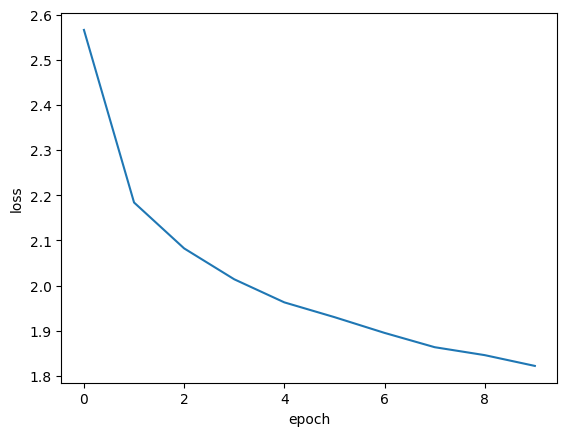

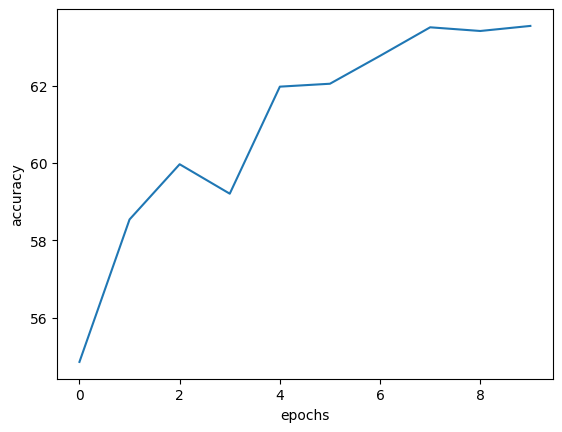

Duration of training: 246.99434075752893


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            # nn.Dropout(0.25),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            # nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)  
pretrained = models.mobilenet_v2(pretrained=True)
pretrained = nn.Sequential(*list(pretrained.children())[:-1])  # Exclude the last FC layer

# pretrained_output_size = pretrained(torch.randn(8, 3, 512, 512)).shape
# print("Pretrained model output size:", pretrained_output_size)

for param in pretrained.parameters():
    param.requires_grad = False

model = nn.Sequential(
    pretrained,
    CustomClassifier(num_classes)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(model.state_dict(), 'mobilenet_512_finetune.pkl')


Training started
Loss-ul la finalul epocii 1: 2.5834501687418117
Acuratetea la finalul epocii 1 este 54.82%
Loss-ul la finalul epocii 2: 2.209175439759056
Acuratetea la finalul epocii 2 este 57.69%
Loss-ul la finalul epocii 3: 2.0923496006093796
Acuratetea la finalul epocii 3 este 60.16%
Loss-ul la finalul epocii 4: 2.0279561717282033
Acuratetea la finalul epocii 4 este 60.44%
Loss-ul la finalul epocii 5: 1.9855199503694037
Acuratetea la finalul epocii 5 este 61.90%
Loss-ul la finalul epocii 6: 1.951175476741476
Acuratetea la finalul epocii 6 este 62.24%
Loss-ul la finalul epocii 7: 1.9110374110760076
Acuratetea la finalul epocii 7 este 62.57%
Loss-ul la finalul epocii 8: 1.902169735422229
Acuratetea la finalul epocii 8 este 62.73%
Loss-ul la finalul epocii 9: 1.8943360725251754
Acuratetea la finalul epocii 9 este 62.97%
Loss-ul la finalul epocii 10: 1.855550883096437
Acuratetea la finalul epocii 10 este 63.52%


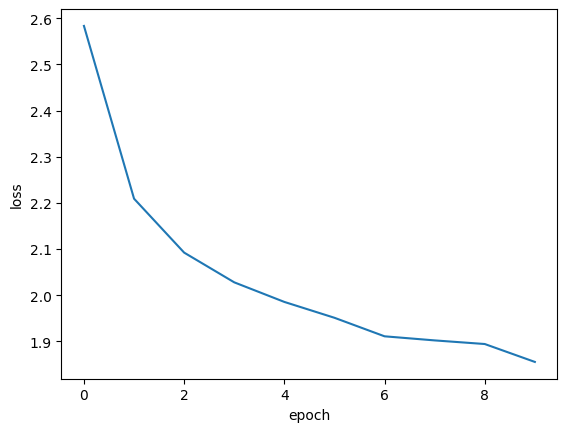

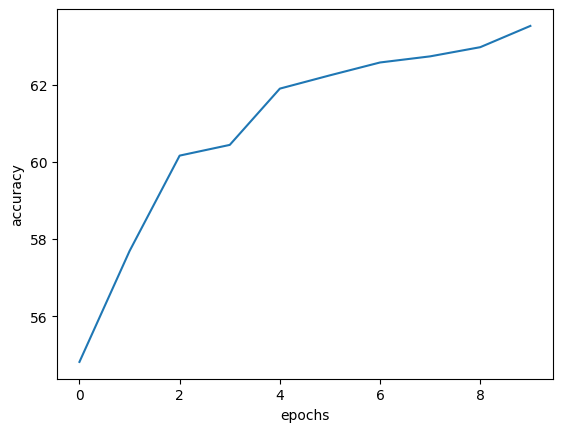

Duration of training: 245.80657353401185


In [4]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            # nn.Dropout(0.25),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            # nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)  
pretrained = models.mobilenet_v2(pretrained=True)
pretrained = nn.Sequential(*list(pretrained.children())[:-1])  # Exclude the last FC layer
0
for param in pretrained.parameters():
    param.requires_grad = False

model = nn.Sequential(
    pretrained,
    CustomClassifier(num_classes)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 10
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(model.state_dict(), 'mobilenet_512_adamw_lr1e-3_wd1e-5.pkl')


c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started
Loss-ul la finalul epocii 1: 3.126774707983036
Acuratetea la finalul epocii 1 este 46.34%
Loss-ul la finalul epocii 2: 2.7562184254926425
Acuratetea la finalul epocii 2 este 51.20%
Loss-ul la finalul epocii 3: 2.646653040643572
Acuratetea la finalul epocii 3 este 53.39%
Loss-ul la finalul epocii 4: 2.58355819252694
Acuratetea la finalul epocii 4 este 55.09%
Loss-ul la finalul epocii 5: 2.5504039348973695
Acuratetea la finalul epocii 5 este 55.94%
Loss-ul la finalul epocii 6: 2.5226340331275865
Acuratetea la finalul epocii 6 este 56.85%
Loss-ul la finalul epocii 7: 2.5016482635472865
Acuratetea la finalul epocii 7 este 56.94%
Loss-ul la finalul epocii 8: 2.4818394768655105
Acuratetea la finalul epocii 8 este 57.37%
Loss-ul la finalul epocii 9: 2.464710800617835
Acuratetea la finalul epocii 9 este 56.74%
Loss-ul la finalul epocii 10: 2.453839152408512
Acuratetea la finalul epocii 10 este 57.51%
Loss-ul la finalul epocii 11: 2.4474585838632614
Acuratetea la finalul epocii

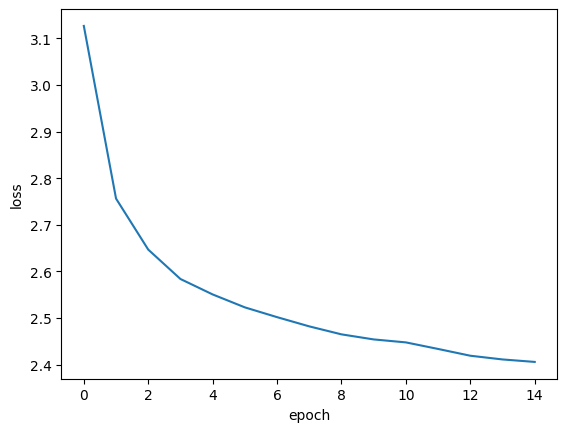

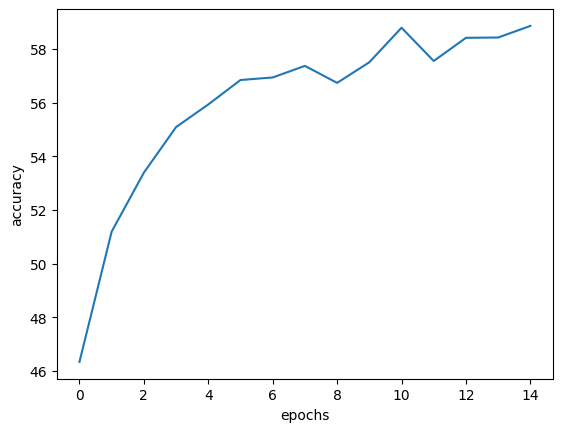

Duration of training: 178.9540207227071


In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)  
pretrained = models.mobilenet_v2(pretrained=True)
pretrained = nn.Sequential(*list(pretrained.children())[:-1])  # Exclude the last FC layer

# pretrained_output_size = pretrained(torch.randn(8, 3, 512, 512)).shape
# print("Pretrained model output size:", pretrained_output_size)

for param in pretrained.parameters():
    param.requires_grad = False

model = nn.Sequential(
    pretrained,
    CustomClassifier(num_classes)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(model.state_dict(), 'mobilenet_512_dropout.pkl')


Training started
Loss-ul la finalul epocii 1: 3.1335709846421045
Acuratetea la finalul epocii 1 este 47.57%
Loss-ul la finalul epocii 2: 2.752986282191261
Acuratetea la finalul epocii 2 este 51.85%
Loss-ul la finalul epocii 3: 2.6399274061410734
Acuratetea la finalul epocii 3 este 53.53%
Loss-ul la finalul epocii 4: 2.5915281501618943
Acuratetea la finalul epocii 4 este 55.33%
Loss-ul la finalul epocii 5: 2.545837941286194
Acuratetea la finalul epocii 5 este 56.06%
Loss-ul la finalul epocii 6: 2.5167921534937996
Acuratetea la finalul epocii 6 este 56.54%
Loss-ul la finalul epocii 7: 2.4951484831693542
Acuratetea la finalul epocii 7 este 57.86%
Loss-ul la finalul epocii 8: 2.4743865972525216
Acuratetea la finalul epocii 8 este 56.97%
Loss-ul la finalul epocii 9: 2.463154854573039
Acuratetea la finalul epocii 9 este 58.41%
Loss-ul la finalul epocii 10: 2.443040578039566
Acuratetea la finalul epocii 10 este 58.88%
Loss-ul la finalul epocii 11: 2.439311148703295
Acuratetea la finalul epoci

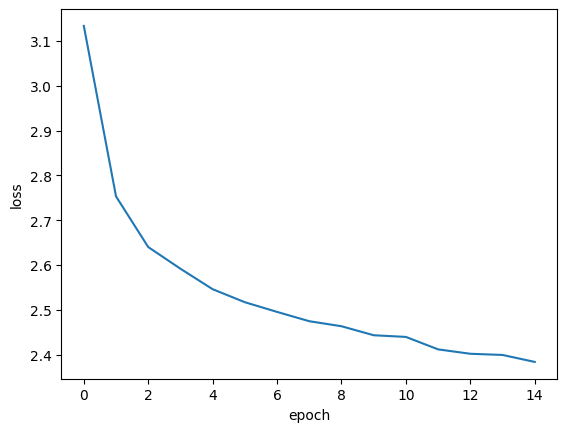

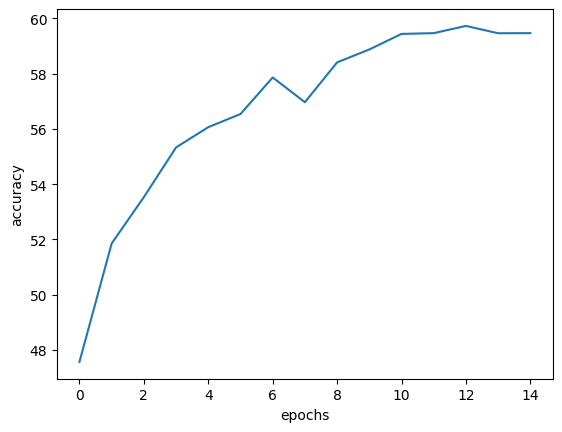

Duration of training: 178.4747559984525


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)  
pretrained = models.mobilenet_v2(pretrained=True)
pretrained = nn.Sequential(*list(pretrained.children())[:-1])  # Exclude the last FC layer
0
for param in pretrained.parameters():
    param.requires_grad = False

model = nn.Sequential(
    pretrained,
    CustomClassifier(num_classes)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(model.state_dict(), 'mobilenet_512_adamw_lr1e-3_wd1e-5_dropout_15epoch.pkl')


In [4]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            # nn.Dropout(0.25),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            # nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)  
pretrained = models.mobilenet_v2(pretrained=True)
pretrained = nn.Sequential(*list(pretrained.children())[:-1])  # Exclude the last FC layer
0
for param in pretrained.parameters():
    param.requires_grad = False

model = nn.Sequential(
    pretrained,
    CustomClassifier(num_classes)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(model.state_dict(), 'mobilenet_512_adamw_lr1e-3_wd1e-5_dropout_15epoch.pkl')


Training started
Loss-ul la finalul epocii 1: 2.7795873396089763
Acuratetea la finalul epocii 1 este 49.98%
Loss-ul la finalul epocii 2: 2.3296350880865218
Acuratetea la finalul epocii 2 este 54.35%
Loss-ul la finalul epocii 3: 2.202690288313938
Acuratetea la finalul epocii 3 este 56.13%
Loss-ul la finalul epocii 4: 2.1245676740608594
Acuratetea la finalul epocii 4 este 58.59%
Loss-ul la finalul epocii 5: 2.0604344762040445
Acuratetea la finalul epocii 5 este 58.55%
Loss-ul la finalul epocii 6: 2.023815238275937
Acuratetea la finalul epocii 6 este 59.52%


KeyboardInterrupt: 